<a href="https://colab.research.google.com/github/ernestojr-7/autoencoded-image/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
from imutils import paths
drive.mount('/content/drive', force_remount=True)
main_dir = '/content/drive/MyDrive/datasets/COVID-19_Radiography_Dataset'
# os.chdir(main_dir)

Mounted at /content/drive


In [2]:
!pip install tensorflow_io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.0 MB 1.2 MB/s 


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_io as tfio
import random
import cv2
from tqdm.notebook import tqdm
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

##Carregamento dos dados

In [4]:
paths_covid = list(paths.list_images(main_dir + '/COVID/'))
paths_covid[:5]

['/content/drive/MyDrive/datasets/COVID-19_Radiography_Dataset/COVID/COVID-3374.png',
 '/content/drive/MyDrive/datasets/COVID-19_Radiography_Dataset/COVID/COVID-3377.png',
 '/content/drive/MyDrive/datasets/COVID-19_Radiography_Dataset/COVID/COVID-3367.png',
 '/content/drive/MyDrive/datasets/COVID-19_Radiography_Dataset/COVID/COVID-3366.png',
 '/content/drive/MyDrive/datasets/COVID-19_Radiography_Dataset/COVID/COVID-3370.png']

In [36]:
len(paths_covid)

3631

In [5]:
paths_norm = list(paths.list_images(main_dir + '/Normal/'))
paths_norm[:5]

['/content/drive/MyDrive/datasets/COVID-19_Radiography_Dataset/Normal/Normal-9109.png',
 '/content/drive/MyDrive/datasets/COVID-19_Radiography_Dataset/Normal/Normal-9107.png',
 '/content/drive/MyDrive/datasets/COVID-19_Radiography_Dataset/Normal/Normal-9103.png',
 '/content/drive/MyDrive/datasets/COVID-19_Radiography_Dataset/Normal/Normal-9082.png',
 '/content/drive/MyDrive/datasets/COVID-19_Radiography_Dataset/Normal/Normal-9097.png']

In [37]:
len(paths_norm)

10192

In [6]:
paths_covid2 = paths_covid[:1000]
paths_norm2 = paths_norm[:1000]
len(paths_covid2), len(paths_norm2)

(1000, 1000)

In [7]:
IMG_WIDTH= 300
IMG_HEIGHT= 300 
target_class = [0, 1]
dataset = []
for target in target_class:
  if target == 0:
    for dir in paths_covid2:
        target_dir = (dir, target)
        dataset.append(target_dir)
  else:
    for dir2 in paths_norm2:
        target_dir2 =  (dir2, target)
        dataset.append(target_dir2)
random.seed(22)
random.shuffle(dataset)
dataset[:3]

[('/content/drive/MyDrive/datasets/COVID-19_Radiography_Dataset/COVID/COVID-401.png',
  0),
 ('/content/drive/MyDrive/datasets/COVID-19_Radiography_Dataset/Normal/Normal-9629.png',
  1),
 ('/content/drive/MyDrive/datasets/COVID-19_Radiography_Dataset/Normal/Normal-9865.png',
  1)]

In [9]:
len(dataset)

2000

In [8]:
def load_image(path, size=(300, 300)):
  img = cv2.imread(path)
  img = cv2.resize(img, size, interpolation=cv2.INTER_CUBIC)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img= img[...,None]
  # img.shape, type(img)
  return img

In [9]:
def convert_dataset_npArray(dataset):
    X_data = []
    for path in tqdm(dataset):
      img = load_image(path)
      # normalization
      img = img/255.0
      X_data.append(img)
    return np.array(X_data)

In [10]:
X = []
y = []
for dt in dataset:
  X.append(dt[0])
  y.append(dt[1])

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val= train_test_split(X[:1000], y[:1000], test_size = 0.20, shuffle = True, random_state=21)
X_train_classifier, X_val_classifier, y_train_classifier, y_val_classifier= train_test_split(X[1000:], y[1000:], test_size = 0.20, shuffle = True, random_state=21)

In [16]:
len(X_train)

800

In [12]:
X_train[0]

'/content/drive/MyDrive/datasets/COVID-19_Radiography_Dataset/COVID/COVID-694.png'

In [13]:
x_train_np = convert_dataset_npArray(X_train)
x_train_np.shape, type(x_train_np)

  0%|          | 0/800 [00:00<?, ?it/s]

((800, 300, 300, 1), numpy.ndarray)

In [14]:
x_val_np = convert_dataset_npArray(X_val)
x_val_np.shape, type(x_val_np)

  0%|          | 0/200 [00:00<?, ?it/s]

((200, 300, 300, 1), numpy.ndarray)

##Autoencoder

[inspirado em...](https://pub.towardsai.net/autoencoders-for-image-labeling-84242decd3d2)

In [15]:
IMG_CHANNELS=1
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [19]:
# Create the Encoder and Decoder
#pass the gray scale input image of size(300,300,1)
inputs = tf.keras.Input(shape=input_shape, name='input_layer')
# Conv Block 1 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(32*2, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)
# Conv Block 2 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64*2, kernel_size=3, strides= 2, padding='same', name='conv_2')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)
# Conv Block 3 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64*2, kernel_size=3, strides=2, padding='same', name='conv_3')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)
encoded_shape= tf.keras.backend.int_shape(encoded)

encoded = tf.keras.layers.Flatten()(encoded)
encoded = tf.keras.layers.Dense(75)(encoded)
encoder=tf.keras.Model(inputs, encoded, name='encoder')
encoder.summary()
latent=tf.keras.Input(shape=(75,))
#Decoder
# DeConv Block 1-> BatchNorm->leaky Relu.
decoded= tf.keras.layers.Dense(np.prod(encoded_shape[1:]))(latent)
decoded= tf.keras.layers.Reshape((encoded_shape[1], encoded_shape[2], encoded_shape[3]))(decoded)
decoded = tf.keras.layers.Conv2DTranspose(64*2, 3, strides= 2, padding='same',name='conv_transpose_1')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(decoded)
# DeConv Block 2-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64*2, 3, strides= 2, padding='same', name='conv_transpose_2')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)
# DeConv Block 3-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(32*2, 3, 1, padding='same', name='conv_transpose_3')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)
# output
outputs = tf.keras.layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)
decoder= tf.keras.Model(latent, outputs, name="decoder")
decoder.summary()
Autoencoder = tf.keras.Model(inputs, decoder(encoder(inputs)),name="autoencoder")  
Autoencoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 300, 1)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 300, 300, 64)      640       
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 300, 300, 64)     256       
 tion)                                                           
                                                                 
 leaky_relu_1 (LeakyReLU)    (None, 300, 300, 64)      0         
                                                                 
 conv_2 (Conv2D)             (None, 150, 150, 128)     73856     
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 150, 150, 128)    512       
 tion)                                                     

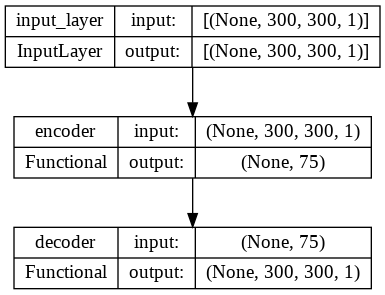

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(Autoencoder, 'autoencoder_no_compress.png', show_shapes=True)

##Treino

In [20]:
# SSIM Loss functtion
def ssim_loss(y_true, y_pred):
  im1 = tf.image.convert_image_dtype(y_true, tf.float32)
  im2 = tf.image.convert_image_dtype(y_pred, tf.float32)
  return 1-tf.reduce_mean(tf.image.ssim(im1, im2, 2.0))
# compile the model 
optimizer = 'adam'
# opt = tf.keras.optimizers.SGD(learning_rate=0.001)
Autoencoder.compile(optimizer=optimizer, loss=ssim_loss)
#training
# callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, mode="min")
history = Autoencoder.fit(x_train_np, x_train_np, validation_data=(x_val_np,x_val_np), batch_size=8, epochs=40, workers=2)

Epoch 1/40
100/100 [==============================] - 39s 377ms/step - loss: 0.2940 - val_loss: 0.2636
Epoch 2/40
100/100 [==============================] - 39s 388ms/step - loss: 0.2019 - val_loss: 0.2584
Epoch 3/40
100/100 [==============================] - 37s 372ms/step - loss: 0.1812 - val_loss: 0.2480
Epoch 4/40
100/100 [==============================] - 37s 369ms/step - loss: 0.1659 - val_loss: 0.2281
Epoch 5/40
100/100 [==============================] - 37s 370ms/step - loss: 0.1588 - val_loss: 0.1880
Epoch 6/40
100/100 [==============================] - 39s 392ms/step - loss: 0.1537 - val_loss: 0.1709
Epoch 7/40
100/100 [==============================] - 39s 393ms/step - loss: 0.1495 - val_loss: 0.1585
Epoch 8/40
100/100 [==============================] - 39s 392ms/step - loss: 0.1471 - val_loss: 0.1664
Epoch 9/40
100/100 [==============================] - 37s 369ms/step - loss: 0.1438 - val_loss: 0.1583
Epoch 10/40
100/100 [==============================] - 39s 393ms/step - l

In [53]:
Autoencoder.save("/content/drive/MyDrive/datasets/encoded/Autoencoder", save_format='h5')

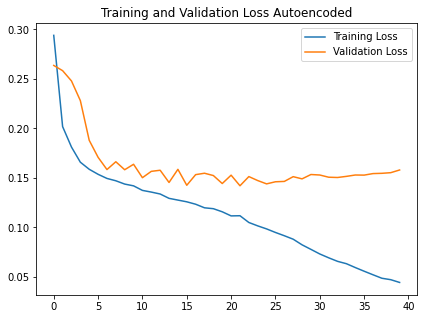

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss Autoencoded')
plt.show()

##visualizando resultados

7/7 [==============================] - 6s 358ms/step


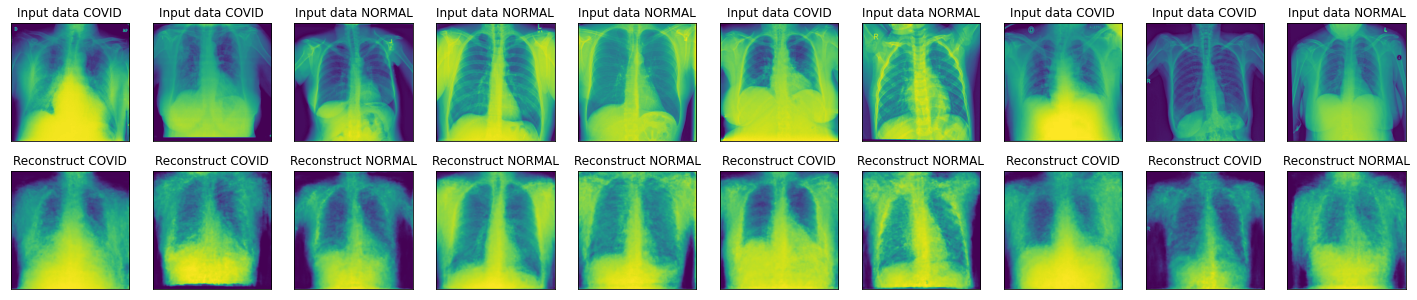

In [23]:
features = Autoencoder.predict(x_val_np)
plt.figure(figsize=(25, 5))
n=10
for i in range(n):
    if y_val[i] == 0:
      label = 'COVID'
    else:
      label = 'NORMAL'
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_val_np[i].reshape(300, 300))
    plt.title("Input data "+ label)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(features[i].reshape(300, 300))
    plt.title("Reconstruct " + label)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [25]:
feature_model = tf.keras.Model(inputs=encoder.input, outputs=encoder.output)
feature_model.save("/content/drive/MyDrive/datasets/encoded/encoder", save_format='h5')

In [26]:
feature_model = keras.models.load_model('/content/drive/MyDrive/datasets/encoded/encoder')
features = feature_model.predict(x_val_np)

7/7 [==============================] - 1s 118ms/step


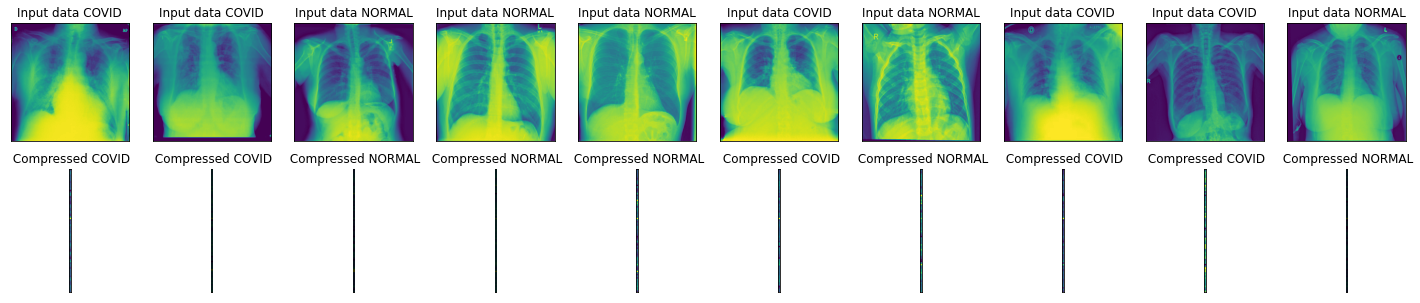

In [27]:
plt.figure(figsize=(25, 5))
n=10
for i in range(n):
    if y_val[i] == 0:
      label = 'COVID'
    else:
      label = 'NORMAL'
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_val_np[i].reshape(300, 300))
    plt.title("Input data "+ label)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(features[i].reshape(75, 1))
    plt.title(" Compressed " + label)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [28]:
reconstruction_model = tf.keras.Model(latent, outputs, name="decoder")
reconstruction_model.save("/content/drive/MyDrive/datasets/encoded/decoder", save_format='h5')

In [29]:
reconstruction_model = keras.models.load_model('/content/drive/MyDrive/datasets/encoded/decoder')
recon_image = reconstruction_model.predict(features)

7/7 [==============================] - 2s 318ms/step


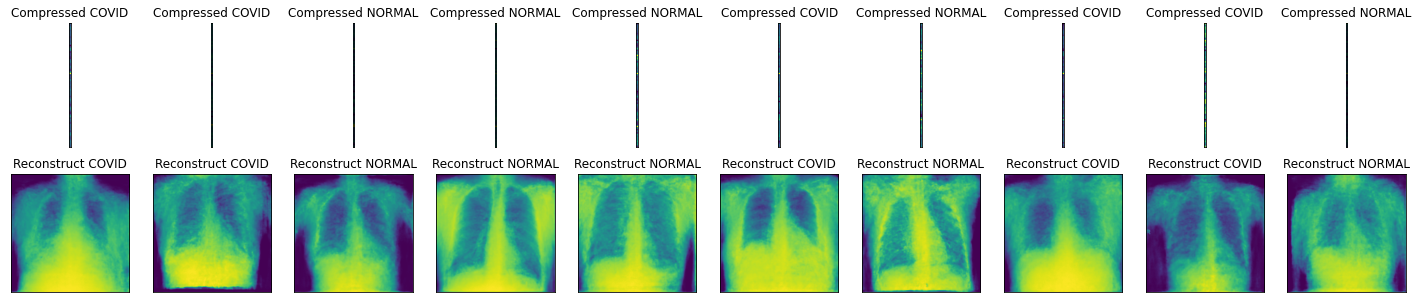

In [30]:
plt.figure(figsize=(25, 5))
n=10
for i in range(10):
    if y_val[i] == 0:
      label = 'COVID'
    else:
      label = 'NORMAL'
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(features[i].reshape(75,1))
    plt.title("Compressed "+ label)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(recon_image[i].reshape(300, 300))
    plt.title("Reconstruct " + label)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

##Salvando imagens reduzidas

In [51]:
def save_img_encoded(model, x, y, path_save=''):
  imgs = model.predict(x)
  for i, idx in tqdm(enumerate(y)):
    img = imgs[i]
    if idx == 0:
      name = f'/covid/COVID-{i}.png'
    else:
      name = f'/normal/NORMAL-{i}.png'
    cv2.imwrite(path_save + name, img)

In [48]:
X_save_np = convert_dataset_npArray(X[1000:])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [52]:
path_save = '/content/drive/MyDrive/datasets/encoded'
save_img_encoded(feature_model, X_save_np, y[1000:], path_save)

32/32 [==============================] - 4s 118ms/step


0it [00:00, ?it/s]

#treino classificador

In [3]:
from PIL import Image,ImageStat
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import os
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import  DataLoader
import torchvision.transforms as transforms
import torch.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics

import json
import random
from tqdm.notebook import tqdm
import time

In [4]:
# Configurando hiperparâmetros.
args = {
    'lr': 1e-2,           # Taxa de aprendizado.
    'weight_decay': 1e-3, # Penalidade L2 (Regularização).
    'batch_size': 8,     # Tamanho do batch.
}

# Definindo dispositivo de hardware
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


##Funções

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(60)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [114]:
import sys
def plot_acc_loss(l_epoca, l_val_loss, l_train_loss, l_acc, title=""):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
    ax1.plot(l_epoca, l_val_loss, label='Validation', )
    ax1.plot(l_epoca, l_train_loss, label='Training')
    ax1.set_xlabel('Epoca')
    ax1.set_ylabel('Loss')
    ax1.legend(labels=['Validation', 'Training'])
    ax1.title.set_text(title)
    
    ax2.plot(l_epoca, l_acc)
    ax2.set_xlabel('Epoca')
    ax2.set_ylabel('Acc')

    plt.show();
    plt.savefig(f'{title}.png')

In [6]:
def plot_confusion_matrix(pred_list, rotulo_list, labels_list = None):
    cm = metrics.confusion_matrix(rotulo_list, pred_list)
    ax = sn.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False);
    if labels_list is not None:
      ax.xaxis.set_ticklabels(labels_list)
      ax.yaxis.set_ticklabels(labels_list, rotation=45)
    plt.title("MATRIX DE CONFUSÃO")
    plt.xlabel("classificação predita")
    plt.ylabel("classificação real")
    plt.show()

In [22]:
def train(train_loader, model, criterion, optimizer):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  # Training mode
  model.to(device)
  model.train()

  lloss  = []
  lacc = []
  l_pred, l_true = [], []
  for _, batch in enumerate(tqdm(train_loader)):
    # dado = x e rotulo = y
    dado, rotulo = batch
    
    # Cast do dado na GPU
    dado = dado.to(device)
    rotulo = rotulo.to(device)
    
    # Forward
    pred = model(dado)
    loss = criterion(pred, rotulo)
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    lloss.append(loss.item())
          
  # lacc = np.asarray(lacc)
  # lloss = np.asarray(lloss)
  # pred_list  = np.asarray(l_pred).ravel()
  # rotulo_list  = np.asarray(l_true).ravel()
  
  # print('______________________________________________________________')
  # print(f'Epoch {epoch}, TRAIN ---> Loss: {np.mean(lloss)})')
  # # print('______________________________________________________________')
  return np.mean(lloss)

In [23]:
def validate(val_loader, model, criterion):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
  # Evaluation mode
  model.to(device)
  model.eval()
 
  lloss  = []
  lacc = []
  lprec, lrec = [], []
  l_pred, l_true = [], []
  with torch.no_grad(): 
    for _, batch in enumerate(tqdm(val_loader)):

        # dado = x e rotulo = y
        dado, rotulo = batch
        
        # Cast do dado na GPU
        dado = dado.to(device)
        rotulo = rotulo.to(device)
        
        # Forward
        pred = model(dado)
        loss = criterion(pred, rotulo)
        lloss.append(loss.cpu().item())

        y_pred = pred.argmax(dim=1).cpu()         
        l_true = l_true + rotulo.tolist()
        l_pred = l_pred + y_pred.tolist()

        acc = metrics.accuracy_score(rotulo.cpu(),y_pred.cpu())
        lacc.append(acc)
        # prec = metrics.precision_score(rotulo.cpu(), y_pred.cpu(), average='macro')
        # lprec.append(prec)
        # rec = metrics.recall_score(rotulo.cpu(), y_pred.cpu(), average='macro')
        # lrec.append(rec)


  # print('______________________________________________________________')
  # print(f'Epoch {epoch}, VALIDATE ---> Loss: {np.mean(lloss)} +/- {np.std(lloss)}, Acc:{np.mean(lacc)}, Prec: {np.mean(prec)}, Rec: {np.mean(rec)} \n')
  # print('______________________________________________________________')
  
  return np.mean(lloss), np.mean(lacc), l_true, l_pred

In [107]:
def routine_train_validate(model, l_labels, dataset_train, dataset_val, n_epoch, criterion, opt):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # TREINO E VALIDACAO
    model.to(device)  
        
    ultima_acc  = 0.0 
    epoch = 0   

    dl_train = torch.utils.data.DataLoader(dataset_train,batch_size = args['batch_size'], num_workers=2, pin_memory=True)
    dl_val   = torch.utils.data.DataLoader(dataset_val,batch_size = args['batch_size'], num_workers=2, pin_memory=True)
    # dl_test  = torch.utils.data.DataLoader(dataset_test,batch_size =args['batch_size'])

    lepoca = []
    lacc  = []
    l_train_loss = []
    l_val_loss = []
    lrec  = []
    lprecision = []

    while epoch < (n_epoch):
        since = time.time()
        # treino
        train_loss = train(dl_train, model, criterion,opt)
        # validacao
        val_loss, val_acc, l_true, l_pred = validate(dl_val, model, criterion)

        lepoca.append(epoch)
        lacc.append(val_acc)
        l_train_loss.append(train_loss)
        l_val_loss.append(val_loss)
        lprecision.append(metrics.precision_score(l_true, l_pred,average='macro',zero_division=1))
        lrec.append(metrics.recall_score(l_true, l_pred, average='macro'))

        epoch+=1

        print("Epoch:{}/{}..".format(epoch+1, n_epoch),
              "Train Loss: {:.3f}..".format(train_loss),
              "Val Loss: {:.3f}..".format(val_loss),
              "Val Acc:{:.3f}..".format(val_acc),
              "Val Prec:{:.3f}..".format(metrics.precision_score(l_true, l_pred,average='macro',zero_division=1)),
              "Val Rec:{:.3f}..".format( metrics.recall_score(l_true, l_pred, average='macro')),
              "Time: {:.2f}m".format((time.time()-since)/60))
        # definir criterio de parada

    finalResultsMeans = {"Acc": np.mean(lacc), "Prec": np.mean(lprecision), "Rec": np.mean(lrec), "Loss": np.mean(l_val_loss)}
    print("\n---------------------------------------Final Results---------------------------------------")
    print("Mean: ", finalResultsMeans)
    plot_confusion_matrix(l_true, l_pred, l_labels)
    return lepoca, l_val_loss, l_train_loss, lacc

In [10]:
def make_instances(dir, samples2class=None):
    instances = []
    cont = 0
    cont_class = 0
    instances = []
    classes = [d.name for d in os.scandir(dir) if d.is_dir()]
    classes.sort()
    # print(f'classes: {classes}')
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    # print(f'class_to_idx: {class_to_idx}')
    for target_class in sorted(class_to_idx.keys()):
            class_index = class_to_idx[target_class]
            target_dir = os.path.join(dir, target_class)
            for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    item = path, class_index
                    # print(item)
                    if samples2class is not None:
                        # seleciona sample_class imagens de cada classe
                        if cont < samples2class and class_index == cont_class:
                          instances.append(item)
                          cont += 1
                        else:
                          cont = 0
                          cont_class += 1
                          break
                    else:
                        instances.append(item)
    # embaralha lista de instances 
    random.seed(22)                 
    random.shuffle(instances)
    return instances

In [11]:
from torch.utils.data import Dataset

from typing import Any,Tuple

class EncodedDataset(Dataset):
    def __init__(self, instances, transform=None,target_transform=None,loader = None):
        self.transform = transform
        self.target_transform = target_transform
        self.instances = instances
        self.loader = loader
        if loader is None:
            self.loader = lambda x: Image.open(x)

    def __getitem__(self,index:int) -> Tuple[Any,Any]:
        path, target = self.instances[index]
        instance = self.loader(path)
        if self.transform is not None:
            instance = self.transform(instance)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return instance,target

    def __len__(self) -> int:
        return len(self.instances)


##Treino com imagens codificadas

In [90]:
dir = '/content/drive/MyDrive/datasets/encoded'
dataset = make_instances(dir)
len(dataset)

1000

In [91]:
dataset[:5]

[('/content/drive/MyDrive/datasets/encoded/normal/NORMAL-803.png', 1),
 ('/content/drive/MyDrive/datasets/encoded/normal/NORMAL-620.png', 1),
 ('/content/drive/MyDrive/datasets/encoded/normal/NORMAL-841.png', 1),
 ('/content/drive/MyDrive/datasets/encoded/covid/COVID-903.png', 0),
 ('/content/drive/MyDrive/datasets/encoded/normal/NORMAL-665.png', 1)]

In [92]:
dataset_train, dataset_val= train_test_split(dataset, test_size = 0.20, shuffle = True, random_state=21)
# dataset_val, dataset_test = train_test_split(dataset_aux, test_size = 0.50, shuffle = True, random_state=21)

In [119]:
# dataset transformation
transform = transforms.Compose([transforms.Grayscale(num_output_channels=3),
                                # transforms.Resize((75,1)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])
                            ])

In [120]:
ds_train = EncodedDataset(dataset_train, transform=transform)
ds_val = EncodedDataset(dataset_val, transform=transform)

In [121]:
name_model = 'resnext50'
model = torchvision.models.resnext50_32x4d(pretrained=True)
criterion = nn.CrossEntropyLoss().to(args['device'])
# optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=0.9)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [122]:
# ajuste da ultima camada
model.fc = nn.Linear(2048,2)

In [97]:
l_labels = ['COVID', 'Normal']

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:2/40.. Train Loss: 0.831.. Val Loss: 0.677.. Val Acc:0.625.. Val Prec:0.636.. Val Rec:0.634.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:3/40.. Train Loss: 0.691.. Val Loss: 0.680.. Val Acc:0.610.. Val Prec:0.604.. Val Rec:0.601.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:4/40.. Train Loss: 0.660.. Val Loss: 0.671.. Val Acc:0.550.. Val Prec:0.569.. Val Rec:0.565.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:5/40.. Train Loss: 0.620.. Val Loss: 0.688.. Val Acc:0.595.. Val Prec:0.620.. Val Rec:0.611.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:6/40.. Train Loss: 0.562.. Val Loss: 0.680.. Val Acc:0.610.. Val Prec:0.627.. Val Rec:0.622.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:7/40.. Train Loss: 0.493.. Val Loss: 0.678.. Val Acc:0.665.. Val Prec:0.662.. Val Rec:0.663.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:8/40.. Train Loss: 0.483.. Val Loss: 0.743.. Val Acc:0.610.. Val Prec:0.621.. Val Rec:0.619.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:9/40.. Train Loss: 0.403.. Val Loss: 0.802.. Val Acc:0.620.. Val Prec:0.622.. Val Rec:0.623.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:10/40.. Train Loss: 0.443.. Val Loss: 0.738.. Val Acc:0.660.. Val Prec:0.664.. Val Rec:0.665.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:11/40.. Train Loss: 0.379.. Val Loss: 0.748.. Val Acc:0.640.. Val Prec:0.645.. Val Rec:0.645.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:12/40.. Train Loss: 0.382.. Val Loss: 0.852.. Val Acc:0.610.. Val Prec:0.625.. Val Rec:0.621.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:13/40.. Train Loss: 0.299.. Val Loss: 0.915.. Val Acc:0.630.. Val Prec:0.633.. Val Rec:0.634.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:14/40.. Train Loss: 0.260.. Val Loss: 0.972.. Val Acc:0.680.. Val Prec:0.681.. Val Rec:0.683.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:15/40.. Train Loss: 0.280.. Val Loss: 0.894.. Val Acc:0.600.. Val Prec:0.613.. Val Rec:0.610.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:16/40.. Train Loss: 0.186.. Val Loss: 1.059.. Val Acc:0.610.. Val Prec:0.616.. Val Rec:0.616.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:17/40.. Train Loss: 0.153.. Val Loss: 1.102.. Val Acc:0.625.. Val Prec:0.632.. Val Rec:0.632.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:18/40.. Train Loss: 0.109.. Val Loss: 1.373.. Val Acc:0.645.. Val Prec:0.656.. Val Rec:0.654.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:19/40.. Train Loss: 0.174.. Val Loss: 1.068.. Val Acc:0.650.. Val Prec:0.650.. Val Rec:0.652.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:20/40.. Train Loss: 0.098.. Val Loss: 1.292.. Val Acc:0.675.. Val Prec:0.685.. Val Rec:0.683.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:21/40.. Train Loss: 0.085.. Val Loss: 1.146.. Val Acc:0.645.. Val Prec:0.654.. Val Rec:0.653.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:22/40.. Train Loss: 0.054.. Val Loss: 1.605.. Val Acc:0.625.. Val Prec:0.626.. Val Rec:0.627.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:23/40.. Train Loss: 0.070.. Val Loss: 1.428.. Val Acc:0.640.. Val Prec:0.645.. Val Rec:0.645.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:24/40.. Train Loss: 0.076.. Val Loss: 1.774.. Val Acc:0.580.. Val Prec:0.592.. Val Rec:0.590.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:25/40.. Train Loss: 0.134.. Val Loss: 2.137.. Val Acc:0.620.. Val Prec:0.633.. Val Rec:0.630.. Time: 0.11m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:26/40.. Train Loss: 0.385.. Val Loss: 0.742.. Val Acc:0.640.. Val Prec:0.640.. Val Rec:0.641.. Time: 0.11m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:27/40.. Train Loss: 0.461.. Val Loss: 0.902.. Val Acc:0.650.. Val Prec:0.685.. Val Rec:0.668.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:28/40.. Train Loss: 0.269.. Val Loss: 1.052.. Val Acc:0.645.. Val Prec:0.663.. Val Rec:0.657.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:29/40.. Train Loss: 0.127.. Val Loss: 1.330.. Val Acc:0.660.. Val Prec:0.696.. Val Rec:0.678.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:30/40.. Train Loss: 0.117.. Val Loss: 1.263.. Val Acc:0.625.. Val Prec:0.649.. Val Rec:0.640.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:31/40.. Train Loss: 0.079.. Val Loss: 1.482.. Val Acc:0.680.. Val Prec:0.707.. Val Rec:0.695.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:32/40.. Train Loss: 0.072.. Val Loss: 1.630.. Val Acc:0.665.. Val Prec:0.671.. Val Rec:0.671.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:33/40.. Train Loss: 0.054.. Val Loss: 1.683.. Val Acc:0.720.. Val Prec:0.727.. Val Rec:0.727.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:34/40.. Train Loss: 0.025.. Val Loss: 1.692.. Val Acc:0.635.. Val Prec:0.663.. Val Rec:0.651.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:35/40.. Train Loss: 0.011.. Val Loss: 1.776.. Val Acc:0.655.. Val Prec:0.673.. Val Rec:0.667.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:36/40.. Train Loss: 0.005.. Val Loss: 1.786.. Val Acc:0.675.. Val Prec:0.691.. Val Rec:0.686.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:37/40.. Train Loss: 0.004.. Val Loss: 1.832.. Val Acc:0.665.. Val Prec:0.679.. Val Rec:0.675.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:38/40.. Train Loss: 0.004.. Val Loss: 1.886.. Val Acc:0.675.. Val Prec:0.691.. Val Rec:0.686.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:39/40.. Train Loss: 0.005.. Val Loss: 1.856.. Val Acc:0.670.. Val Prec:0.685.. Val Rec:0.681.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:40/40.. Train Loss: 0.002.. Val Loss: 1.935.. Val Acc:0.670.. Val Prec:0.688.. Val Rec:0.682.. Time: 0.10m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:41/40.. Train Loss: 0.002.. Val Loss: 1.984.. Val Acc:0.665.. Val Prec:0.684.. Val Rec:0.677.. Time: 0.10m

---------------------------------------Final Results---------------------------------------
Mean:  {'Acc': 0.640375, 'Prec': 0.6525770214341868, 'Rec': 0.6490530303030304, 'Loss': 1.2388426910797135}


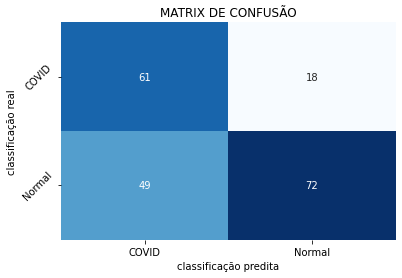

In [123]:
l_epoca, l_val_loss, l_train_loss, l_acc = routine_train_validate(model, l_labels, ds_train, ds_val, 40, criterion, optimizer)

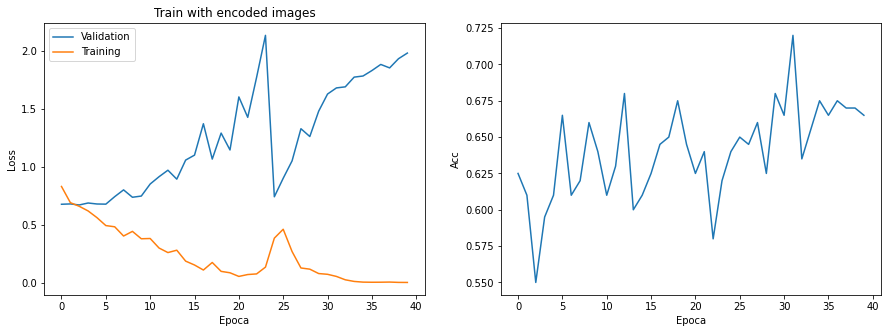

<Figure size 432x288 with 0 Axes>

In [138]:
plot_acc_loss(l_epoca, l_val_loss, l_train_loss, l_acc, 'Train with encoded images')

##Treino com imagens originais

In [129]:
dataset_train2, dataset_val2 = train_test_split(dataset[1000:], test_size = 0.20, shuffle = True, random_state=21)

In [130]:
len(dataset_train2)

800

In [131]:
# dataset transformation
transform = transforms.Compose([transforms.Grayscale(num_output_channels=3),
                                transforms.Resize((300,300)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])
                            ])

In [132]:
ds_train = EncodedDataset(dataset_train2, transform=transform)
ds_val = EncodedDataset(dataset_val2, transform=transform)

In [133]:
model2 = torchvision.models.resnext50_32x4d(pretrained=True)
# ajuste da ultima camada
model2.fc = nn.Linear(2048,4)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
l_labels2 = ['COVID', 'Normal']

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:2/40.. Train Loss: 0.996.. Val Loss: 1.236.. Val Acc:0.635.. Val Prec:0.764.. Val Rec:0.667.. Time: 0.44m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:3/40.. Train Loss: 0.795.. Val Loss: 2.070.. Val Acc:0.500.. Val Prec:0.737.. Val Rec:0.545.. Time: 0.44m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:4/40.. Train Loss: 0.602.. Val Loss: 1.052.. Val Acc:0.615.. Val Prec:0.769.. Val Rec:0.650.. Time: 0.43m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:5/40.. Train Loss: 0.413.. Val Loss: 0.758.. Val Acc:0.750.. Val Prec:0.802.. Val Rec:0.770.. Time: 0.43m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:6/40.. Train Loss: 0.319.. Val Loss: 0.467.. Val Acc:0.845.. Val Prec:0.848.. Val Rec:0.839.. Time: 0.44m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:7/40.. Train Loss: 0.455.. Val Loss: 0.399.. Val Acc:0.855.. Val Prec:0.865.. Val Rec:0.864.. Time: 0.43m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:8/40.. Train Loss: 0.315.. Val Loss: 0.339.. Val Acc:0.880.. Val Prec:0.879.. Val Rec:0.878.. Time: 0.43m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:9/40.. Train Loss: 0.264.. Val Loss: 0.321.. Val Acc:0.865.. Val Prec:0.864.. Val Rec:0.863.. Time: 0.43m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:10/40.. Train Loss: 0.288.. Val Loss: 0.417.. Val Acc:0.830.. Val Prec:0.830.. Val Rec:0.833.. Time: 0.43m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:11/40.. Train Loss: 0.263.. Val Loss: 0.434.. Val Acc:0.830.. Val Prec:0.850.. Val Rec:0.842.. Time: 0.43m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:12/40.. Train Loss: 0.199.. Val Loss: 1.079.. Val Acc:0.740.. Val Prec:0.817.. Val Rec:0.764.. Time: 0.44m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:13/40.. Train Loss: 0.155.. Val Loss: 0.424.. Val Acc:0.880.. Val Prec:0.879.. Val Rec:0.882.. Time: 0.44m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:14/40.. Train Loss: 0.157.. Val Loss: 0.748.. Val Acc:0.780.. Val Prec:0.830.. Val Rec:0.799.. Time: 0.44m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:15/40.. Train Loss: 0.074.. Val Loss: 0.183.. Val Acc:0.940.. Val Prec:0.939.. Val Rec:0.939.. Time: 0.43m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:16/40.. Train Loss: 0.032.. Val Loss: 0.135.. Val Acc:0.960.. Val Prec:0.960.. Val Rec:0.960.. Time: 0.44m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:17/40.. Train Loss: 0.024.. Val Loss: 0.168.. Val Acc:0.945.. Val Prec:0.945.. Val Rec:0.944.. Time: 0.43m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:18/40.. Train Loss: 0.021.. Val Loss: 0.130.. Val Acc:0.960.. Val Prec:0.959.. Val Rec:0.962.. Time: 0.44m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:19/40.. Train Loss: 0.014.. Val Loss: 0.231.. Val Acc:0.950.. Val Prec:0.950.. Val Rec:0.955.. Time: 0.45m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:20/40.. Train Loss: 0.005.. Val Loss: 0.190.. Val Acc:0.935.. Val Prec:0.936.. Val Rec:0.940.. Time: 0.44m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:21/40.. Train Loss: 0.001.. Val Loss: 0.159.. Val Acc:0.955.. Val Prec:0.954.. Val Rec:0.957.. Time: 0.43m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:22/40.. Train Loss: 0.000.. Val Loss: 0.155.. Val Acc:0.955.. Val Prec:0.954.. Val Rec:0.957.. Time: 0.43m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:23/40.. Train Loss: 0.000.. Val Loss: 0.154.. Val Acc:0.955.. Val Prec:0.954.. Val Rec:0.957.. Time: 0.43m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:24/40.. Train Loss: 0.000.. Val Loss: 0.154.. Val Acc:0.955.. Val Prec:0.954.. Val Rec:0.957.. Time: 0.43m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:25/40.. Train Loss: 0.000.. Val Loss: 0.154.. Val Acc:0.955.. Val Prec:0.954.. Val Rec:0.957.. Time: 0.43m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:26/40.. Train Loss: 0.000.. Val Loss: 0.154.. Val Acc:0.955.. Val Prec:0.954.. Val Rec:0.957.. Time: 0.43m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:27/40.. Train Loss: 0.000.. Val Loss: 0.155.. Val Acc:0.955.. Val Prec:0.954.. Val Rec:0.957.. Time: 0.43m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:28/40.. Train Loss: 0.000.. Val Loss: 0.155.. Val Acc:0.955.. Val Prec:0.954.. Val Rec:0.957.. Time: 0.44m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:29/40.. Train Loss: 0.000.. Val Loss: 0.156.. Val Acc:0.955.. Val Prec:0.954.. Val Rec:0.957.. Time: 0.43m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:30/40.. Train Loss: 0.000.. Val Loss: 0.156.. Val Acc:0.955.. Val Prec:0.954.. Val Rec:0.957.. Time: 0.43m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:31/40.. Train Loss: 0.000.. Val Loss: 0.157.. Val Acc:0.955.. Val Prec:0.954.. Val Rec:0.957.. Time: 0.43m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:32/40.. Train Loss: 0.000.. Val Loss: 0.157.. Val Acc:0.960.. Val Prec:0.959.. Val Rec:0.962.. Time: 0.43m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:33/40.. Train Loss: 0.000.. Val Loss: 0.158.. Val Acc:0.960.. Val Prec:0.959.. Val Rec:0.962.. Time: 0.43m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:34/40.. Train Loss: 0.000.. Val Loss: 0.158.. Val Acc:0.960.. Val Prec:0.959.. Val Rec:0.962.. Time: 0.43m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:35/40.. Train Loss: 0.000.. Val Loss: 0.159.. Val Acc:0.960.. Val Prec:0.959.. Val Rec:0.962.. Time: 0.43m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:36/40.. Train Loss: 0.000.. Val Loss: 0.159.. Val Acc:0.960.. Val Prec:0.959.. Val Rec:0.962.. Time: 0.43m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:37/40.. Train Loss: 0.000.. Val Loss: 0.159.. Val Acc:0.960.. Val Prec:0.959.. Val Rec:0.962.. Time: 0.43m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:38/40.. Train Loss: 0.000.. Val Loss: 0.160.. Val Acc:0.960.. Val Prec:0.959.. Val Rec:0.962.. Time: 0.43m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:39/40.. Train Loss: 0.000.. Val Loss: 0.160.. Val Acc:0.960.. Val Prec:0.959.. Val Rec:0.962.. Time: 0.43m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:40/40.. Train Loss: 0.000.. Val Loss: 0.160.. Val Acc:0.960.. Val Prec:0.959.. Val Rec:0.962.. Time: 0.43m


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:41/40.. Train Loss: 0.000.. Val Loss: 0.161.. Val Acc:0.960.. Val Prec:0.959.. Val Rec:0.962.. Time: 0.44m

---------------------------------------Final Results---------------------------------------
Mean:  {'Acc': 0.8950000000000001, 'Prec': 0.9124577204407849, 'Rec': 0.9009848484848485, 'Loss': 0.35204120625404933}


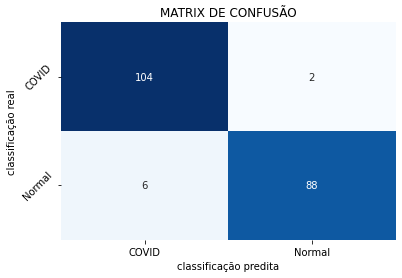

In [134]:
criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = optim.SGD(model2.parameters(), lr=args['lr'], momentum=0.9)
l_epoca2, l_val_loss2, l_train_loss2, l_acc2 = routine_train_validate(model2, l_labels2, ds_train, ds_val, 40, criterion, optimizer)

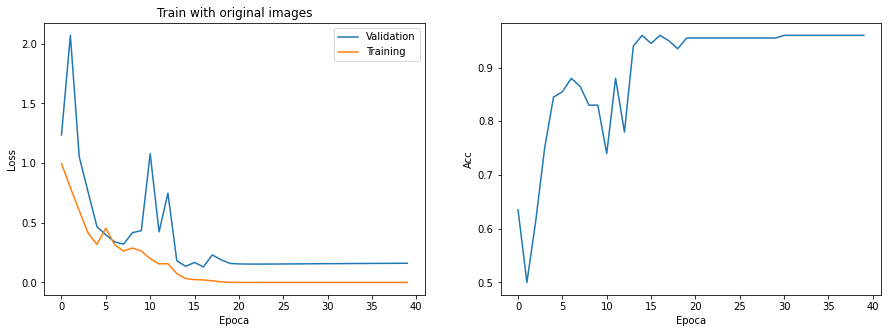

<Figure size 432x288 with 0 Axes>

In [137]:
name_model = 'resnext50'
plot_acc_loss(l_epoca2, l_val_loss2, l_train_loss2, l_acc2, 'Train with original images')